# BM-dataset: GNN prediction of the adsorption energy compared to DFT

This notebook reproduces the final results shown in the paper (parity plot in Figure4).

In [12]:
import sys, os
sys.path.insert(0, '../src')
sys.path.insert(0, '../src/gnn_eads')
from subprocess import PIPE, Popen

import pandas as pd
import numpy as np
import cycler
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.font_manager import FontProperties
legend_font = FontProperties(family='Arial', style='normal', size=9)
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn.metrics import r2_score

from gnn_eads.functions import contcar_to_graph, get_graph_conversion_params
from gnn_eads.graph_tools import extract_adsorbate, get_number_atoms
from gnn_eads.nets import PreTrainedModel
from gnn_eads.constants import MOL_ELEM, ENCODER, ELEMENT_LIST, FULL_ELEM_LIST

## Step 1: Retrieve DFT adsorption energy for the BM-dataset and save as .csv file

In [13]:
BM_PATH = "/home/smorandi/Desktop/gnn_eads/data/BM_dataset"  # path to the BM dataset
Label, Family, Metal, Etot_DFT, Eslab_DFT, Emol_DFT = [], [], [], [], [], []
for family in os.listdir(BM_PATH):
    #print(family)
    family_path = os.path.join(BM_PATH, family)
    for (dirpath, dirnames, filenames) in os.walk(family_path):
        for calc in dirnames:
            if "-" not in calc:  # Gas-phase calculation
                continue
            if "0000" in calc:   # Metal slab calculation
                continue
            calc_path = os.path.join(dirpath, calc)
            #print(calc_path)
            Label.append(calc)
            Family.append(family)
            Metal.append(calc.split("-")[0])
            p1 = Popen(["grep", "energy  w", os.path.join(calc_path, "OUTCAR")], stdout=PIPE)
            p2 = Popen(["tail", "-1"], stdin=p1.stdout, stdout=PIPE)
            p3 = Popen(["awk", "{print $NF}"], stdin=p2.stdout, stdout=PIPE)
            Etot_DFT.append(float(p3.communicate()[0]))  # Total energy (adsorbate + metal)
            gas_path = os.path.join(dirpath, calc.split("-")[-1])
            slab_path = os.path.join(dirpath, calc.split("-")[0] + "-" + "0000")
            p1 = Popen(["grep", "energy  w", os.path.join(gas_path, "OUTCAR")], stdout=PIPE)
            p2 = Popen(["tail", "-1"], stdin=p1.stdout, stdout=PIPE)
            p3 = Popen(["awk", "{print $NF}"], stdin=p2.stdout, stdout=PIPE)
            Emol_DFT.append(float(p3.communicate()[0]))  # Gas-phase energy
            p1 = Popen(["grep", "energy  w", os.path.join(slab_path, "OUTCAR")], stdout=PIPE)
            p2 = Popen(["tail", "-1"], stdin=p1.stdout, stdout=PIPE)
            p3 = Popen(["awk", "{print $NF}"], stdin=p2.stdout, stdout=PIPE)
            if family == "Plastics" or (family == "Polyurethanes" and calc.split("-")[0] == "au"):
                Eslab_DFT.append(float(p3.communicate()[0])*4)  # Metal slab energy
            else:
                Eslab_DFT.append(float(p3.communicate()[0]))  # Metal slab energy

df = pd.DataFrame({"Label": Label, "Family": Family, "Metal": Metal, "Etot_DFT": Etot_DFT, "Eslab_DFT": Eslab_DFT, "Emol_DFT": Emol_DFT})
df["Eads_DFT"] = df["Etot_DFT"] - df["Eslab_DFT"] - df["Emol_DFT"]
df.to_csv(BM_PATH + "/DFT_BM.csv", index=False)
df.head()

,Label,Family,Metal,Etot_DFT,Eslab_DFT,Emol_DFT,Eads_DFT
0,ni-mol1,Biomass,ni,-699.003184,-429.518132,-266.620332,-2.864720
1,ni-mol2,Biomass,ni,-698.489544,-429.518132,-266.582128,-2.389283
2,ni-mol3,Biomass,ni,-585.906515,-429.518132,-153.601859,-2.786525
3,ni-mol4,Biomass,ni,-600.110308,-429.518132,-168.674337,-1.917839
4,ni-mol5,Biomass,ni,-593.315922,-429.518132,-162.199307,-1.598483


## Step 2: Load GNN model

In [14]:
MODEL_NAME = "best_13Dec2022_hypopt_250e"
MODEL_PATH = "/home/smorandi/teklahome/{}".format(MODEL_NAME)  
model = PreTrainedModel(MODEL_PATH)
print(model)

GNN pretrained model for DFT ground state energy prediction.
Creation date: 2022-12-16 17:53:30.893848
Model path: /home/smorandi/teklahome/best_13Dec2022_hypopt_250e
Number of parameters: 281857
Model size: 1.08MB


## Step 3: Load .csv file as Pandas dataframe

In [15]:
df = pd.read_csv(BM_PATH + "/DFT_BM.csv")
df.head()

,Label,Family,Metal,Etot_DFT,Eslab_DFT,Emol_DFT,Eads_DFT
0,ni-mol1,Biomass,ni,-699.003184,-429.518132,-266.620332,-2.864720
1,ni-mol2,Biomass,ni,-698.489544,-429.518132,-266.582128,-2.389283
2,ni-mol3,Biomass,ni,-585.906515,-429.518132,-153.601859,-2.786525
3,ni-mol4,Biomass,ni,-600.110308,-429.518132,-168.674337,-1.917839
4,ni-mol5,Biomass,ni,-593.315922,-429.518132,-162.199307,-1.598483


## Step 4: Create directory for storing results

In [16]:
NEWDIR = "../performance_BMdataset/{}".format(MODEL_NAME)
if not os.path.exists(NEWDIR):
    os.mkdir(NEWDIR)
else:
    print("Folder already exists, change dirname in this cell")

## Step 5: Generate graphs and GNN predictions

In [17]:
# Function for counting non-H atoms in adsorbates
CONS = [ELEMENT_LIST.index(element) for element in ["C", "O", "N", "S"]]
adsorbate_atom_counter_noH = lambda graph: int(graph.x.sum(axis=0)[CONS].sum().item())
Etot_GNN, Emol_GNN, metal_presence_graph , adsorbate_atoms_noH = [], [], [], []
for sample in df.iterrows():
    # Read CONTCAR files for adsorption system and gas-phase molecule
    contcar_ads = os.path.join(BM_PATH, sample[1]["Family"], sample[1]["Label"], "CONTCAR")
    contcar_mol = os.path.join(BM_PATH, sample[1]["Family"], sample[1]["Label"].split("-")[-1], "CONTCAR")
    # Convert to graphs
    graph_ads = contcar_to_graph(contcar_ads, model.g_tol, model.g_sf, model.g_metal_2nn)
    graph_mol = contcar_to_graph(contcar_mol, model.g_tol, model.g_sf, model.g_metal_2nn)
    # Check correctness of metal presence in the adsorption graphs
    if graph_ads.num_nodes == graph_mol.num_nodes:
        metal_presence_graph.append("Wrong")
    else:
        metal_presence_graph.append("Correct")
    # Get number of non-H atoms in adsorbate
    adsorbate_atoms_noH.append(adsorbate_atom_counter_noH(graph_mol))
    # Get GNN predictions
    Etot_GNN.append(model.evaluate(graph_ads))
    Emol_GNN.append(model.evaluate(graph_mol))

df["Etot_GNN"] = Etot_GNN
df["Emol_GNN"] = Emol_GNN
df["Eads_GNN"] = df["Etot_GNN"] - df["Emol_GNN"]
df["Metal_presence_graph"] = metal_presence_graph
df["Adsorbate_atoms_noH"] = adsorbate_atoms_noH
df["Error"] = df["Eads_DFT"] - df["Eads_GNN"]
df["Error_abs"] = np.abs(df["Error"])
df["Error_per_noHatom"] = df["Error_abs"] / df["Adsorbate_atoms_noH"]
df.to_csv(NEWDIR + "/BM_predictions.csv", index=False)
df.head()

,Label,Family,Metal,Etot_DFT,Eslab_DFT,Emol_DFT,Eads_DFT,Etot_GNN,Emol_GNN,Eads_GNN,Metal_presence_graph,Adsorbate_atoms_noH,Error,Error_abs,Error_per_noHatom
0,ni-mol1,Biomass,ni,-699.003184,-429.518132,-266.620332,-2.864720,-271.777752,-269.455661,-2.322091,Correct,23,-0.542629,0.542629,0.023593
1,ni-mol2,Biomass,ni,-698.489544,-429.518132,-266.582128,-2.389283,-271.064324,-269.455661,-1.608663,Correct,23,-0.780620,0.780620,0.033940
2,ni-mol3,Biomass,ni,-585.906515,-429.518132,-153.601859,-2.786525,-157.056043,-154.812859,-2.243185,Correct,13,-0.543340,0.543340,0.041795
3,ni-mol4,Biomass,ni,-600.110308,-429.518132,-168.674337,-1.917839,-171.801833,-169.814134,-1.987699,Correct,14,0.069860,0.069860,0.004990
4,ni-mol5,Biomass,ni,-593.315922,-429.518132,-162.199307,-1.598483,-164.752666,-163.327996,-1.424670,Correct,13,-0.173812,0.173812,0.013370


In [18]:
MAE = df["Error_abs"].mean()
MAE_per_noHatom = df["Error_per_noHatom"].mean()
R2 = r2_score(df["Eads_DFT"], df["Eads_GNN"])
MAPE = (df["Error_abs"] / df["Eads_DFT"]).mean()
print("MAE: {:.2f} eV".format(MAE))
print("MAE per non-H atom: {:.2f} eV".format(MAE_per_noHatom))
print("R2: {:.2f}".format(R2))
print("MAPE: {:.2f} %".format(MAPE*100))

MAE: 0.85 eV
MAE per non-H atom: 0.05 eV
R2: -0.16
MAPE: 236.45 %


## Step 6: Create parity plot DFT vs GNN for the adsorption energy of the BM-dataset

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

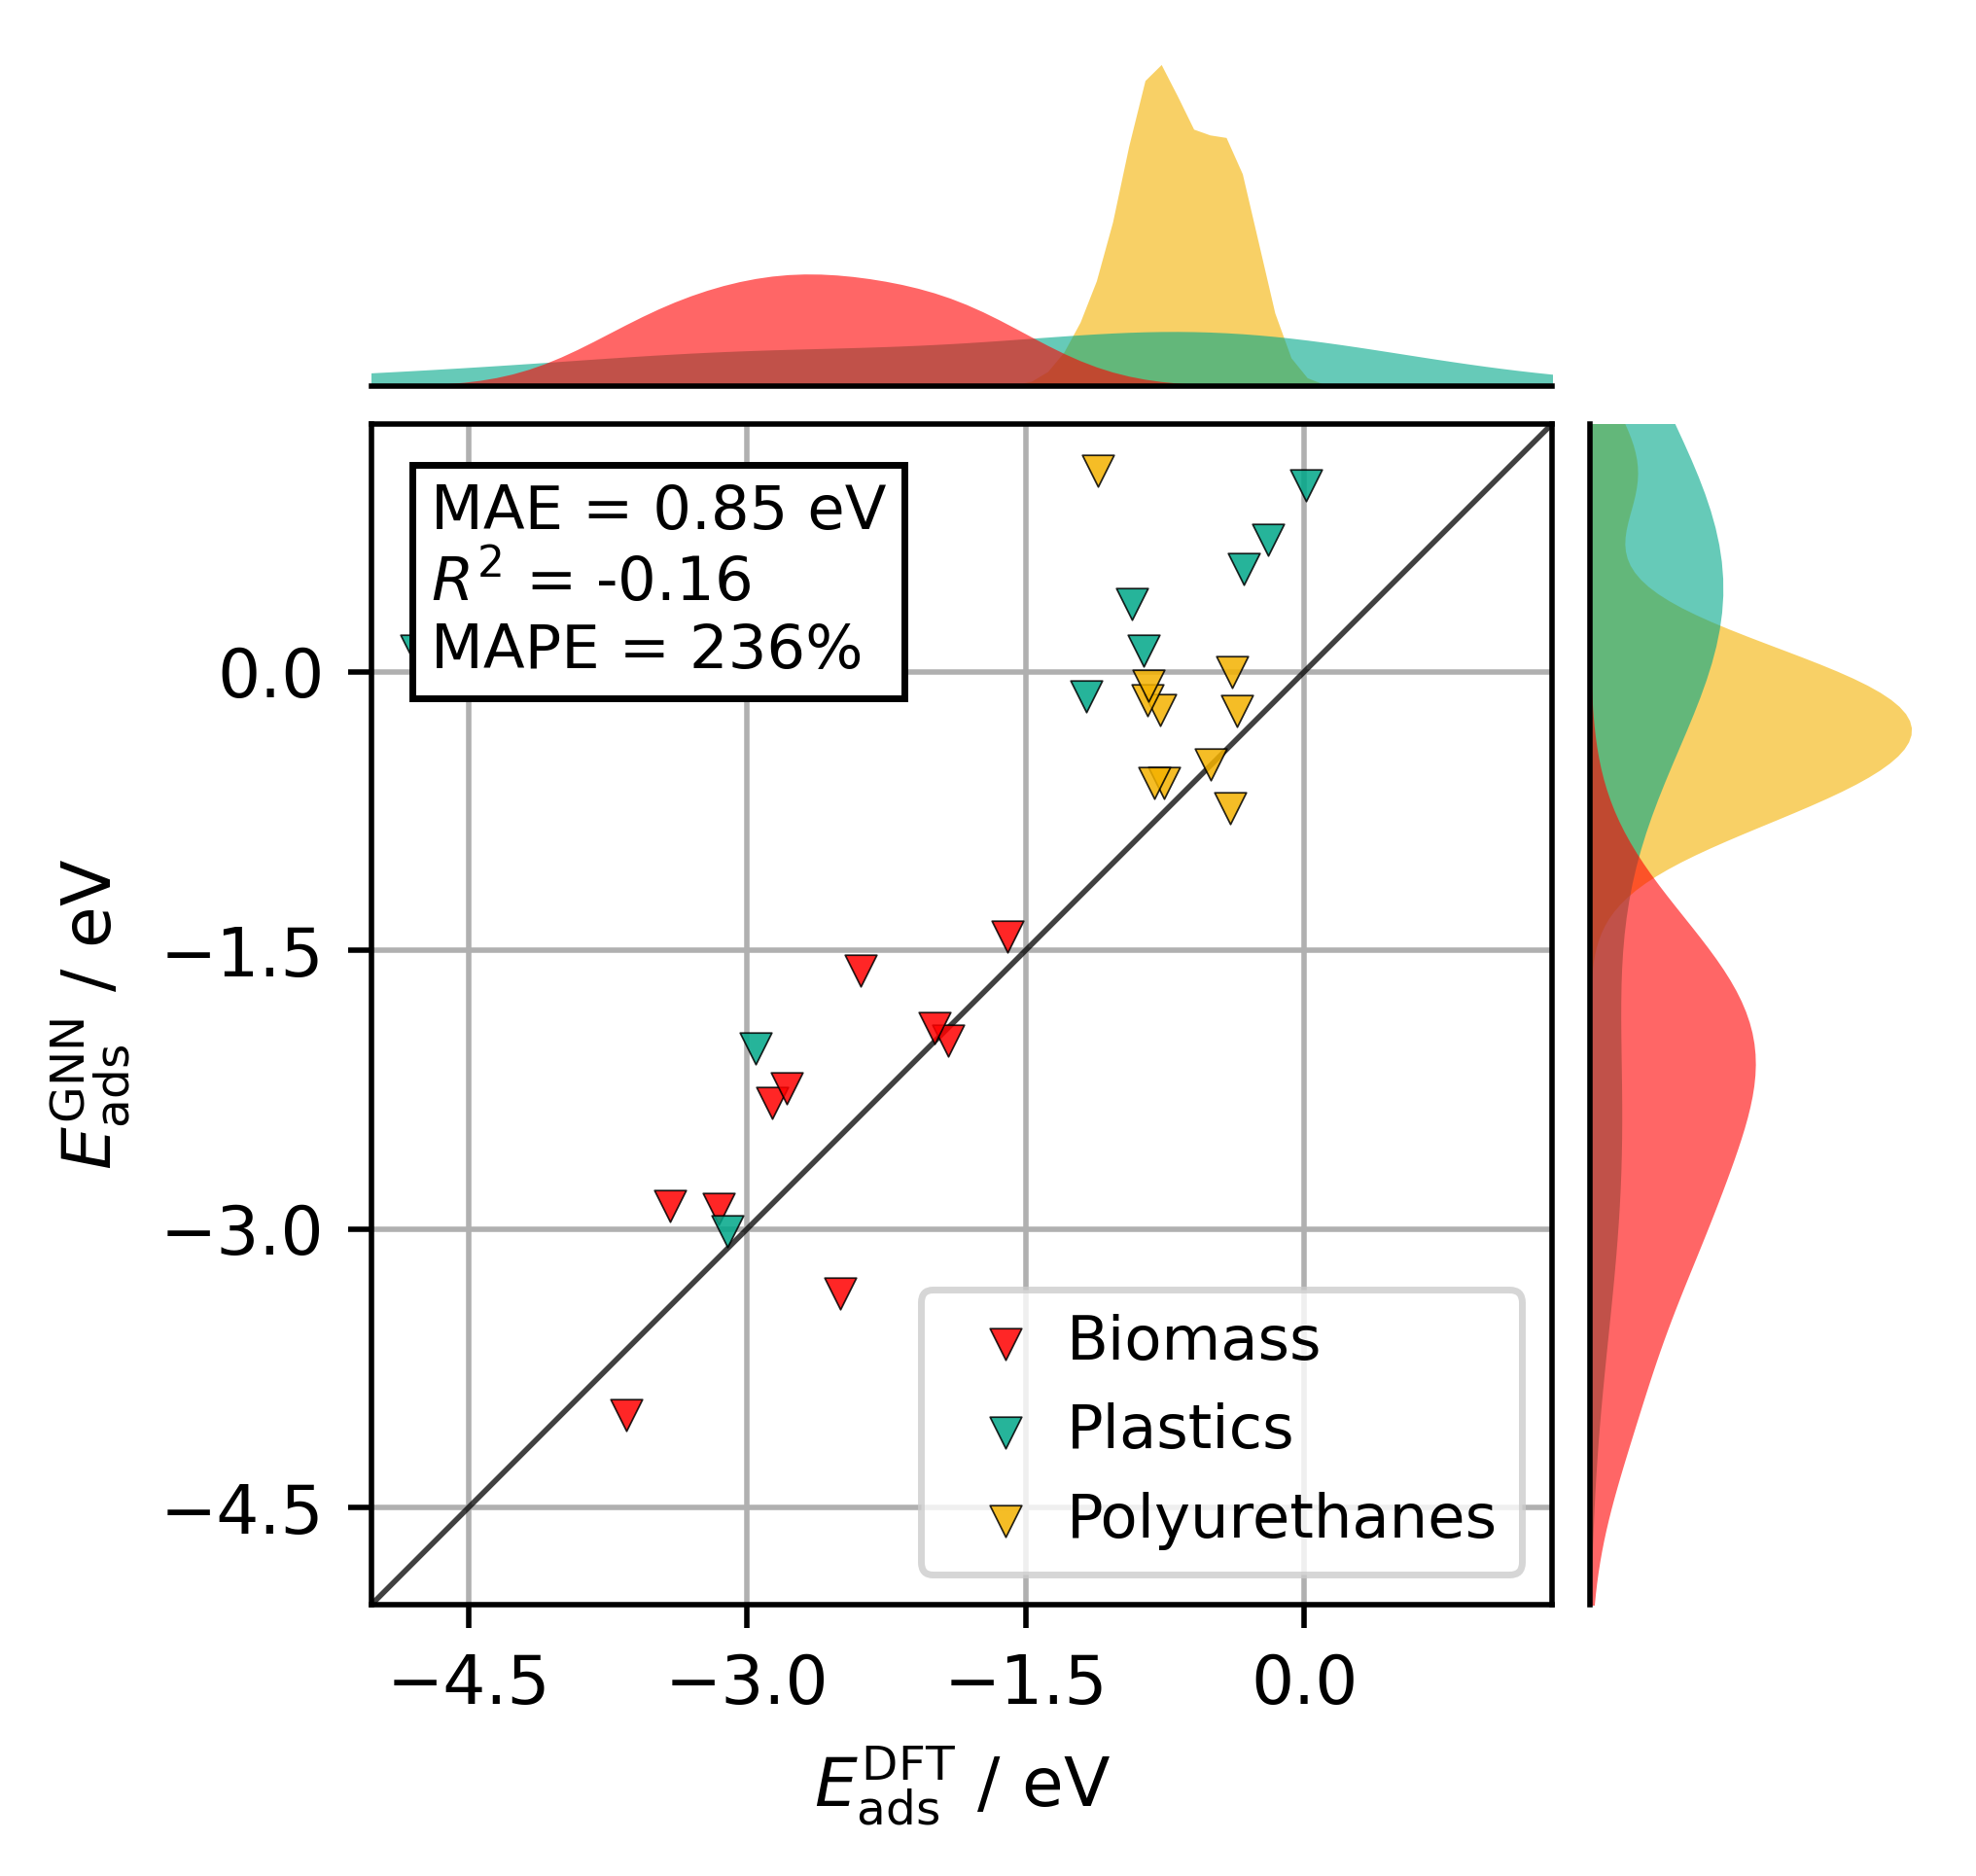

In [19]:
fig = plt.figure(figsize=(4,4), dpi=500)
params = {'mathtext.default': 'regular'}          
plt.rcParams.update(params)
gs = GridSpec(4, 4)
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax_scatter = fig.add_subplot(gs[1, 0])
ax_hist_x = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
ax_hist_y = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

ax_scatter.set_ylabel('$\mathit{E}_{ads}^{GNN}$ / eV')
ax_scatter.set_xlabel('$\mathit{E}_{ads}^{DFT}$ / eV')
PALETTE = ["#FF0000", "#00A789", "#F4B200"]
ax_scatter.set_prop_cycle(cycler.cycler(color=PALETTE))
for label, series in df.groupby("Family"):
        ax_scatter.scatter(series["Eads_DFT"], series["Eads_GNN"],
                   s=22, marker="v", alpha=0.85, edgecolors="black", linewidths=0.25, zorder=2, label=label)
ax_scatter.yaxis.set_major_locator(MaxNLocator(5)) 
ax_scatter.xaxis.set_major_locator(MaxNLocator(5)) 
legend_font = FontProperties(family='Arial', style='normal', size=9)
ax_scatter.legend(loc="lower right", prop=legend_font, handletextpad=0)
#lims = [-5.2, 0.2]  # max of both axes
lims = [np.min([ax_scatter.get_xlim(), ax_scatter.get_ylim()]),  # min of both axes
         np.max([ax_scatter.get_xlim(), ax_scatter.get_ylim()])]  # max of both axes
ax_scatter.plot(lims, lims, 'k-', alpha=0.75, zorder=1, linewidth=0.8)
ax_scatter.set_aspect('equal')
ax_scatter.set_xlim(lims)
ax_scatter.set_ylim(lims)
ax_scatter.set_axisbelow("True")
ax_scatter.grid()
text = "MAE = {:.2f} eV\n$\mathit{{R}}^{{2}}$ = {:.2f}\nMAPE = {:.0f}%".format(MAE, R2, MAPE*100)
props = dict(boxstyle='square', facecolor='white', edgecolor='black')
ax_scatter.text(0.05, 0.95, text, transform=ax_scatter.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# histogram GNN
ax_hist_y.tick_params(axis="y", labelleft=False, left=False)
ax_hist_y.tick_params(axis="x", labelbottom=False, bottom=False)
sns.kdeplot(data=df,
            y='Eads_GNN',
            hue='Family',
            hue_order=['Biomass', 'Plastics', 'Polyurethanes'],
            ax=ax_hist_y,
            legend=False, 
            palette=PALETTE, 
            fill=True, 
            multiple="layer", 
            alpha=0.6, 
            linewidth=0, 
            common_norm=False, 
            common_grid=False, 
            gridsize=100)
ax_hist_y.spines.right.set_visible(False)
ax_hist_y.spines.top.set_visible(False)
ax_hist_y.spines.bottom.set_visible(False)
# histogram DFT 
ax_hist_x.tick_params(axis="x", labelbottom=False, bottom=False)
ax_hist_x.tick_params(axis="y", labelleft=False, left=False)
sns.kdeplot(data=df,
            x='Eads_DFT',
            hue='Family',
            hue_order=['Biomass', 'Plastics', 'Polyurethanes'],
            ax=ax_hist_x,
            legend=False, 
            palette=PALETTE, 
            fill=True, 
            multiple="layer", 
            alpha=0.6, 
            linewidth=0, 
            common_norm=False, 
            common_grid=True, 
            gridsize=100)
ax_hist_x.spines.right.set_visible(False)
ax_hist_x.spines.top.set_visible(False)
ax_hist_x.spines.left.set_visible(False)
plt.savefig("../performance_BMdataset/{}/parity_plot_{}.svg".format(MODEL_NAME, MODEL_NAME), bbox_inches='tight')
plt.savefig("../performance_BMdataset/{}/parity_plot_{}.png".format(MODEL_NAME, MODEL_NAME), bbox_inches='tight')
